# chaii - Hindi and Tamil Question Answering

### Competition Description: 
- With nearly 1.4 billion people, India is the second-most populated country in the world. Yet Indian languages, like Hindi and Tamil, are underrepresented on the web. Popular Natural Language Understanding (NLU) models perform worse with Indian languages compared to English, the effects of which lead to subpar experiences in downstream web applications for Indian users.


- Predicting answers to questions is a common NLU task, but not for Hindi and Tamil. Current progress on multilingual modeling requires a concentrated effort to generate high-quality datasets and modelling improvements. Additionally, for languages that are typically underrepresented in public datasets, it can be difficult to build trustworthy evaluations. 

### About the languages spoken in India:
- Languages spoken in India belong to several language families, the major ones being the Indo-Aryan languages spoken by 78.05% of Indians and the Dravidian languages spoken by 19.64% of Indians. 
- Languages spoken by the remaining 2.31% of the population belong to the Austroasiatic, Sino–Tibetan, Tai–Kadai and a few other minor language families and isolates.
- 283 India has the world's fourth highest number of languages (447), after Nigeria (524), Indonesia (710) and Papua New Guinea (840).
- The Eighth Schedule of the Indian Constitution lists 22 languages, which have been referred to as scheduled languages and given recognition, status and official encouragement. 
- In addition, the Government of India has awarded the distinction of classical language to Kannada, Malayalam, Odia, Sanskrit, Tamil and Telugu. Classical language status is given to languages which have a rich heritage and independent nature.

### The Task
- We are given questions in Tamil/Hindi about some Wikipedia articles, and we have to generate the answers for those questions using our model.

### Dataset
- We have been provided with a new question-answering dataset with question-answer pairs, and it goes by the name chaii-1. The task is straightforward.

### Evaluation Metric
- The predictions would be evaluated using word-level Jaccard score. 
- A sample code has also been provided for the same.

In [1]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

### Languages of India : Region Wise

![Languages of India](https://4.bp.blogspot.com/-LVOObgDzDjw/WbSFz80TLZI/AAAAAAABBvM/t-u8-pf2h7cDM5sf_zI2XhtuE_25R4QUACLcBGAs/s1600/Languages-Map.jpg)

### Languages of India : % Speakers Wise
![The % of people speaking these languages](https://qph.fs.quoracdn.net/main-qimg-cbcf7165e9ef13620a378555d781a83f)

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from transformers import pipeline

import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
from wordcloud import WordCloud
from plotly.offline import iplot
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from wordcloud import WordCloud
from collections import Counter

from spacy.lang.hi import Hindi
from spacy.lang.ta import Tamil
from spacy.lang.hi import STOP_WORDS as hindi_stopwords
from spacy.lang.ta import STOP_WORDS as tamil_stopwords


seed=111
np.random.seed(seed)

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
# Path to the data diectory
data_dir = Path("../input/chaii-hindi-and-tamil-question-answering/")

# Read the training and test csv files
train_df = pd.read_csv(data_dir / "train.csv", encoding="utf8")
test_df = pd.read_csv(data_dir / "test.csv", encoding="utf8")

# How many training and test samples have been provided?
print("Number of training samples: ", len(train_df))
print("Number of test samples: ", len(test_df))

Number of training samples:  1114
Number of test samples:  5


- There are only ~1100 training samples, meaning we are in a low data regime, suggesting that transfer-learning and fine-tuning are the best shots if we are going to use DNNs for this task. 
- This doesn't mean we shouldn't build your models!
- Let's take a look at the training data and the test data

# Basic Data Exploration

In [4]:
train_df.head(2)

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil


In [5]:
test_df.head(2)

,id,context,question,language
0,22bff3dec,"ज्वाला गुट्टा (जन्म: 7 सितंबर 1983; वर्धा, महा...",ज्वाला गुट्टा की माँ का नाम क्या है,hindi
1,282758170,गूगल मानचित्र (Google Maps) (पूर्व में गूगल लो...,गूगल मैप्स कब लॉन्च किया गया था?,hindi


### Observations : 

- There can be English words as well in the given questions answer_start column isn't in the test dataset, but it gives important information about the training dataset, the starting character for the context
- The language column is present in both train and test. 
- One of the things that we can try is to build two separate models, one for Hindi and one for Tamil, and then make the predictions accordingly using the values in this column

# Distribution of the languages in the training dataset

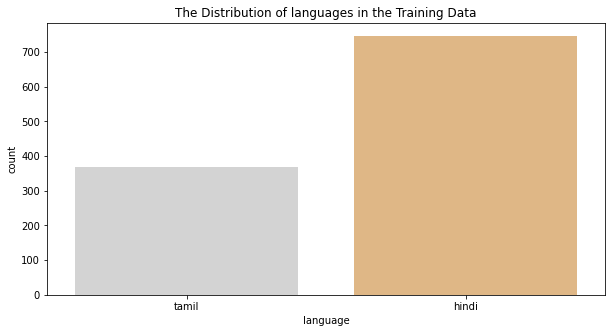

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x="language",palette=['lightgrey','#eeb977'])
plt.title("The Distribution of languages in the Training Data")
plt.show()

### Observations:
- The number of instances for Hindi language is almost double the number of instance of Tamil language in the training dataset. Let's also get the actual count to see the difference

In [7]:
# Get the actual count values
train_df["language"].value_counts()

hindi    746
tamil    368
Name: language, dtype: int64

# Remove punctuation
All the questions presented here are represented with a question mark. We will simply remove it and along with it, we will alos strip any whitespace around the text

In [8]:
train_df["question"] = train_df["question"].str.replace("?", "", regex=False).str.strip()
train_df.head(2)

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்,காசுமீரில்,2358,tamil


# WordCloud
We will generate two wordclouds, one for each language.

In [9]:
# Get the text for both the languages
tamil_text = " ".join(train_df[train_df["language"]=="tamil"]["question"])
hindi_text = " ".join(train_df[train_df["language"]=="hindi"]["question"])

For generating the wordlcoud, we need the right font

- [Font for Hindi](http://www.lipikaar.com/support/download-unicode-fonts-for-hindi-marathi-sanskrit-nepali)
- [Font for Tamil](http://www.lipikaar.com/support/download-unicode-fonts-for-tamil)

In [10]:
# Download and extract the fonts
!wget -q http://www.lipikaar.com/sites/www.lipikaar.com/themes/million/images/support/fonts/Devanagari.zip
!wget -q http://www.lipikaar.com/sites/www.lipikaar.com/themes/million/images/support/fonts/Tamil.zip

!unzip -qq Devanagari.zip
!unzip -qq Tamil.zip

In [11]:
# Get the tokens and frequencies for Hindi language

hindi_nlp = Hindi()
hindi_doc = hindi_nlp(hindi_text)
hindi_tokens = set([token.text for token in hindi_doc])
hindi_tokens_counter = Counter(hindi_tokens)


# Get the tokens and frequencies for Tamil language
tamil_nlp = Tamil()
tamil_doc = hindi_nlp(tamil_text)
tamil_tokens = set([token.text for token in tamil_doc])
tamil_tokens_counter = Counter(tamil_tokens)

In [12]:
def plot_wordcloud(
    font_path,
    frequencies,
    stopwords,
    width=500,
    height=500,
    background_color="white",
    collocations=True,
    min_font_size=6,
):
    """Generates wordcloud from word frequencies."""
    
    wordcloud = WordCloud(font_path=font_path,
                      width=width,
                      colormap= 'YlOrBr',
                      height=height,
                      background_color=background_color,
                      stopwords=stopwords,
                      collocations=collocations,
                      min_font_size=min_font_size).generate_from_frequencies(frequencies)

    
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

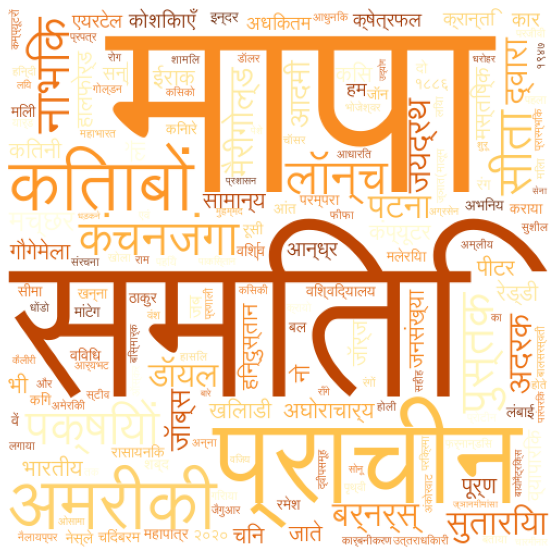

In [13]:
# Plot the wordcloud for hindi langauge
plot_wordcloud(font_path="Devanagari/Lohit-Devanagari.ttf",
               frequencies=hindi_tokens_counter,
               stopwords=hindi_stopwords
              )

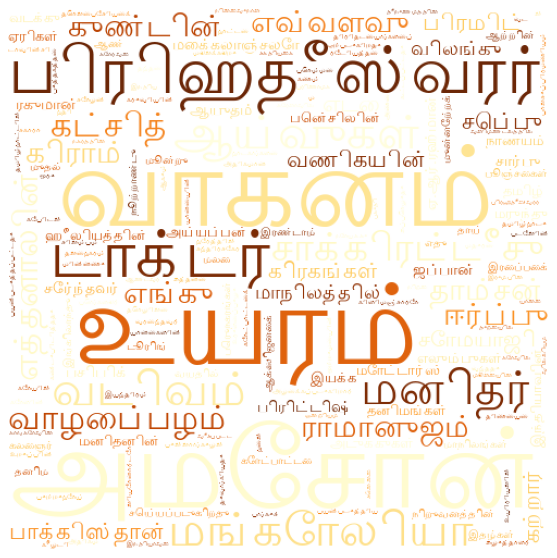

In [14]:
# Plot the wordcloud for tamil language
plot_wordcloud(font_path="Tamil/Lohit-Tamil.ttf",
               frequencies=tamil_tokens_counter,
               stopwords=tamil_stopwords
              )

# Exploratory Data Analysis 
- Looking at number of tokens, characters, unknown tokens, what languages are in text, and more
- There might be some useful post-processing approaches that could be explored based on this work

In [15]:
import pandas as pd
from collections import Counter
from transformers import AutoTokenizer
import plotly.express as px

df = pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/train.csv")

## Tokenizing

In [16]:
tokenizer = AutoTokenizer.from_pretrained("../input/xlm-roberta-squad2/deepset/xlm-roberta-base-squad2")

context_tokens = [tokenizer(x)["input_ids"] for x in df["context"]]
question_tokens = [tokenizer(x)["input_ids"] for x in df["question"]]
answer_tokens = [tokenizer(x)["input_ids"] for x in df["answer_text"]]

df["num_tokens_context"] = [len(x) for x in context_tokens]
df["num_chars_context"] = [len(x) for x in df["context"]]
df["num_tokens_question"] = [len(x) for x in question_tokens]
df["num_chars_question"] = [len(x) for x in df["question"]]
df["num_tokens_answer"] = [len(x) for x in answer_tokens]
df["num_chars_answer"] = [len(x) for x in df["answer_text"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1492 > 512). Running this sequence through the model will result in indexing errors


## Checking for unknown tokens

In [17]:
context_tokens_flat = sum(context_tokens, [])
question_tokens_flat = sum(question_tokens, [])
answer_tokens_flat =  sum(answer_tokens, [])

unk = tokenizer.unk_token

unk in context_tokens_flat, unk in question_tokens_flat, unk in answer_tokens_flat

(False, False, False)

## Looking at character level

In [18]:
contexts = df["context"]
answers = df["answer_text"]

all_chars_ctx = "".join(contexts)
all_chars_ans = "".join(answers)

unq_chars_ctx = sorted(list(set(all_chars_ctx)))
unq_chars_ans = sorted(list(set(all_chars_ans)))

### Observations: 

About 190 contexts and 120 answers are duplicates

Looking at what types of characters are in the context.
It turns out there are many languages in addition to Hindi and Tamil. I see:

- English
- Latin
- Greek
- Japanese
- Chinese
- Arabic
- Nepali

#### A multi-lingual model will be very important

In [19]:
"".join(unq_chars_ctx)

'\t\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\xa0¢£¨«®¯°±²³´µ·º»½¾ÁÉÍÎÖ×ÚÜßàáâãäåæçèéêëìíîïðñóôö÷øùúüýĀāăąćčďĐēěğīİıķŁłńņŋŌōŚśŠšťūźžƒǎǐǔɐɑɒɔɖəɛɜɟɡɣɦɨɪɫɲɳɹɽɾʀʁʂʃʈʊʋʌʏʒʔʝʰʲʿˈˌː˙˚̞̥̪̰̀́̃̚ͰͱͲͳͶͷΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩάέήίαβγδεζηθικλμνξοπρςστυφχψωόύώϘϙϚϛϜϝϞϟϠϡϷϸϺϻАБВДЗИКЛМНОПРСТУФХЧЭЯабвгдежзийклмнопрстухцчшыьюяёҙԵանրևְִֵֶַָֹּׁׂאבהחיכלמנסרשתءآأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىيَُِّْپچډښکگہۂیܒܠऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎॏॐ॒॑॓॔ॕॖॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡॢॣ।॥०१२३४५६७८९॰ॱॲॳॴॵॶॷॸॹॺॻॼॽॾॿংঅআউএওকগঙচছজঞটঠডঢণতথদধনপবভমযরলশষসহ়ািীুৃেো্ৎ০১২৬ਕਗਜਦਨਮਰਲਸਾਿੀੁੂ੍ੱંઈટણદનપબભમરલળવસાિીુેો્ஃஅஆஇஈஉஊஎஏஐஒஓஔகஙசஜஞடணதநனபமயரறலளழவஷஸஹாிீுூெேைொோௌ்ௗ௦௧௭௯ంగజటడదనబమయరసహాిుూెైో్ಂಅಕಗಟದನಬರಳಸಾಿುೂೆ್ംകഗതദനപബമരലവശസാിീുൊ്กคงญดทนบปพมรวสหอะัาีุเ่๋་གདལསྭကဋတပမယရသာိီူေ်ဿባዓይគងតរវអ្ḗḥḭḲṃṅṇṣṭẓảậἀἄἈἐἒἤἦἴἶἸὀὂὕὖὦὨὰὶᾶῆῑῖῥῦῶ\u2009\u200b\u200c\u200d\u200e‑–—‘’“”„†‡•…‰′⁄\u2061€₹←↑→↓↦⇒∅∆∈∑−∗∘√∝∞∠∫∮≈≠≡≤≥⊂⋅⋆⋯⏟◆●ⲁⲓⲣⲫⲱ【】あいうえかくこしだちつてとなにのはふほまやゅょらんアスプル与世中九京人住信備儲元克分初券加

### Observation : 
- Answer characters are less varied
- Noticed one of my predictions having a parenthesis around it which made the jaccard score 0. (1990 compared to 1990. 
- It might be a good idea to clean un-balanced punctuation or non-letters (commas, periods) at the beginning/end of answers. 
- Might be wrong, but it looks like the only languages in the answer are English, Hindi, and Tamil.

In [20]:
"".join(unq_chars_ans)

' "%\',-./0123456789:;ABCEGHILMOPSUWabcdeghijklmnopqrstuvxyz°²ँंःअआइईउऊऋएऐऑओऔकखगघचछजझञटठडणतथदधनपफबभमयरलवशषसह़ािीुूृॅेैॉोौ्ॠ।०१२३४५६७८९॰ஃஅஆஇஈஉஎஏஐஒஓகஙசஜஞடணதநனபமயரறலளழவஷஸஹாிீுூெேைொோௌ்௭\u200d–‘’₹'

### Observation:
- Answers with periods are often for numbers or dates.


***கி.மு means BC and கி.பி means AD***


***ई.पू. means BC and ई means AD***

- Would guess that the answers that end in ... or start with . are annotator mistakes. 
- There are some inconsistencies with AD and BC ending in periods (263 and 288) though it might have to do with the source text. Might be worth probing.

In [21]:
answers[answers.str.contains(r"\.")][1:5]

15     கி.மு. ஐந்தாம் நூற்றாண்டில்
36                  அ. இர. ரகுமான்
47       1,568.7 square kilometres
112                 6400 கி.மீ.கள்
Name: answer_text, dtype: object

## Context characters

Looking mostly Hindi and Tamil in the top 50 characters

In [22]:
most_common = Counter(all_chars_ctx).most_common(50)
"".join([x[0] for x in most_common])
x=[x[0] for x in most_common]
y=[x[1] for x in most_common]
px.bar(x=[x[0] for x in most_common], y=[x[1] for x in most_common], color_discrete_sequence =['#eeb977']*len(x),labels={"x": "character", "y": "count"})

In [23]:
most_common_ans = Counter(all_chars_ans).most_common(50)
px.bar(x=[x[0] for x in most_common_ans], y=[x[1] for x in most_common_ans], color_discrete_sequence =['#eeb977']*len(x), labels={"x": "character", "y": "count"})

### Observation:

- For the Answer characters some numbers showing up! 

### Number of tokens in context

- Long contexts are probably harder because the model can not look at everything at once. 
- Even Big Bird can't do 14k tokens. 
- Maybe there could be an approach to identify the chunk of 1,000 or 500 tokens from where the answer is likely, and then that smaller chunk goes into the QA model.

In [24]:
px.histogram(df, x="num_tokens_context", color="language",color_discrete_sequence=['#eeb977','darkgrey'])

### What fraction of the contexts are below a certain length?

In [25]:
only_hindi = df[df["language"]=="hindi"]
only_tamil = df[df["language"]=="tamil"]
num_hindi = len(only_hindi)
num_tamil = len(only_tamil)

lengths = list(range(0, df["num_tokens_context"].max(), 25))
hindi_counts = []
tamil_counts = []
for l in lengths:
    hindi_counts.append((only_hindi["num_tokens_context"]<=l).sum()/num_hindi)
    tamil_counts.append((only_tamil["num_tokens_context"]<=l).sum()/num_tamil)

counts_df = pd.DataFrame(data={"count": hindi_counts+tamil_counts, "length": lengths*2, "language": ["hindi"]*len(hindi_counts)+["tamil"]*len(tamil_counts)})
    
px.line(counts_df, x="length", y="count", color="language", color_discrete_sequence=['#eeb977','darkgrey'],labels={"count": "fraction below length"})

In [26]:
px.histogram(df, x="num_tokens_answer", color="language", color_discrete_sequence=['#eeb977','darkgrey'])

# Baseline Model

In [27]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from torch.optim import Adam,AdamW
from torch.utils.data import SequentialSampler
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import StratifiedKFold
from transformers import XLMRobertaTokenizer,XLMRobertaModel,AutoTokenizer,XLMRobertaModel,XLMRobertaConfig,AutoModel,AutoConfig
from transformers import logging
from transformers import (
    get_cosine_schedule_with_warmup, 
    get_cosine_with_hard_restarts_schedule_with_warmup
)

logging.set_verbosity_error()

In [28]:
config = {
    'base_model':"../input/xlm-roberta-squad2/deepset/xlm-roberta-base-squad2",
    'batch_size':16,
    "epochs":2,
    'folds':5,
    'device':torch.device('cuda')
}

In [29]:
class ChaiiDataset(Dataset):
    
    def __init__(self,df,max_len=356,doc_stride=128):
        
        self.df = df
        self.max_len = max_len 
        self.doc_stride = doc_stride
        self.labelled = 'answer_text' in df
        self.tokenizer = AutoTokenizer.from_pretrained(config['base_model'],add_special_tokens=True)        
        self.tokenized_samples = self.tokenizer(
                                self.df['context'].values.tolist(),
                                self.df['question'].values.tolist(),
                                truncation="only_first",
                                max_length=self.max_len,
                                stride=self.doc_stride,
                                return_overflowing_tokens=True,
                                return_offsets_mapping=True,
                                padding="max_length")
        
    
        
    def __getitem__(self,idx):
        
        data = {}
        ids,mask,offset = self.tokenized_samples['input_ids'][idx],\
                        self.tokenized_samples['attention_mask'][idx],\
                        self.tokenized_samples['offset_mapping'][idx]
        
        data['index'] = idx
        data['ids'] = torch.tensor(ids)
        data['mask'] = torch.tensor(mask)
        data['offset'] = offset
        if self.labelled:
            
            answer_text,start,end = self.get_targets(idx)
            data['answer_text'] = answer_text
            data['start'] = torch.tensor(start)
            data['end'] = torch.tensor(end)
            
        
        return data
        
    
    def get_targets(self,idx):
        
        df_index = self.tokenized_samples['overflow_to_sample_mapping'][idx]
        start_char = (self.df.iloc[df_index]['answer_start'])
        end_char = start_char + len(self.df.iloc[df_index]['answer_text'])
        offset = self.tokenized_samples['offset_mapping'][idx]
        sequence_ids = self.tokenized_samples.sequence_ids(idx)
        end_offset = len(self.tokenized_samples['input_ids'][idx])-1
        start_offset = 1
        while sequence_ids[end_offset] != 0:
            end_offset -= 1
            
            
        start_idx = 0;end_idx=0
        ## answer not in context
        if (start_char > offset[end_offset][0] or end_char < offset[start_offset][0]):
            #print("In first loop")
            start_idx = 0;end_idx=0
            answer_text=""
            
        ## answer partially in context
        elif ((start_char <= offset[end_offset][0]) and (end_char >  offset[end_offset][0])):
            #print("in second loop")
            start_idx = 0;end_idx=0
            answer_text = ""
        
        ## answer fully inside context
        else:
            #print("In third loop")
            i=0
            while (start_idx < len(offset) and offset[i][0]<=start_char and offset[i][1]<start_char):
                start_idx+=1
                i+=1
            end_idx = i
            while (end_idx < len(offset) and offset[i][1]<end_char):
                end_idx+=1
                i+=1
            answer_text = self.df.iloc[df_index]['answer_text'].strip()
            
        
        return answer_text,start_idx, end_idx 
    
    
    def post_process(self,batch,pred_start,pred_end):
        batch_pred,indices = [],[]
        for idx,start,end in zip(batch['index'],pred_start,pred_end):
            a,b = self.tokenized_samples['offset_mapping'][idx][start][0],self.tokenized_samples['offset_mapping'][idx][end][1]
            df_index = self.tokenized_samples['overflow_to_sample_mapping'][idx]

            if a>b:
                batch_pred.append("")
                indices.append(df_index)
            else: 
                pred_string = self.df.iloc[df_index]['context'][a:b].strip()   
                batch_pred.append(pred_string.strip())
                indices.append(df_index)

        return batch_pred,indices

    
    
    
    def __len__(self):
        return len(self.tokenized_samples['overflow_to_sample_mapping'])

In [30]:
class ChaiiModel(nn.Module):
    
    def __init__(self):
        super(ChaiiModel,self).__init__()
        
        self.model_config = AutoConfig.from_pretrained(config['base_model'])
        self.model_config.return_dict=True
        self.model_config.output_hidden_states=True
        self.model = AutoModel.from_pretrained(config['base_model'],config=self.model_config)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.model_config.hidden_size,2)
        self.__init_weights(self.fc)
        
    def __init_weights(self,module):
        if isinstance(module,nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        
    def forward(self,input_ids,attention_mask):
        
        output = self.model(input_ids,attention_mask)
        hidden_states = output['hidden_states'][-1]
        #x = torch.stack([hidden_states[-1],hidden_states[-2],hidden_states[-3],hidden_states[-4]])
        #x = torch.mean(x,0)
        x = self.dropout(hidden_states)
        x = self.fc(x)
        start_logits,end_logits = x.split(1,dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
                
        return start_logits, end_logits

In [31]:
def safe_div(x,y):
    if y == 0:
        return 1
    return x / y

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return safe_div(float(len(c)) , (len(a) + len(b) - len(c)))

def get_jaccard_score(y_true,y_pred):
    assert len(y_true)==len(y_pred)
    score=0.0
    for i in range(len(y_true)):
        score += jaccard(y_true[i], y_pred[i])
        
    return score

def chaii_loss(start_logits, end_logits, start_positions, end_positions):
    ce_loss = nn.CrossEntropyLoss()
    start_loss = ce_loss(start_logits, start_positions)
    end_loss = ce_loss(end_logits, end_positions)    
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [32]:
def train_model(model,dataloaders,criterion,optimizer,scheduler=None,epochs=3,filename='saved.pth'):
    
    
    model.cuda()
    
    for epoch in range(epochs):
        for phase in ['train','valid']:
            
            if phase=='train':
                model.train()
                
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_jaccard = 0.0
            bar = tqdm(dataloaders[phase],total=len(dataloaders[phase]))
            for i,data in enumerate(bar):
                
                input_ids = data['ids'].cuda()
                masks = data['mask'].cuda()
                start,end = data['start'].cuda(),data['end'].cuda()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):

                    start_logits, end_logits = model(input_ids, masks)
                    loss = criterion(start_logits,end_logits,start,end)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler!=None:
                            scheduler.step()

                    epoch_loss += loss.item() * len(input_ids)
                    
                    start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
                    end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()
                    
                    pred_start,pred_end = start_logits.argmax(axis=1),end_logits.argmax(axis=1)
                    prediction_strings,_ = dataloaders[phase].dataset.post_process(data,pred_start, pred_end)
                    
                    epoch_jaccard += get_jaccard_score(data['answer_text'],prediction_strings)
                    
                
                    bar.set_postfix(Batch=i, Phase=phase, loss= epoch_loss/(config['batch_size']*(i+1)),
                        jaccard_score = epoch_jaccard/(config['batch_size']*(i+1)))
                
            epoch_loss = epoch_loss / len(dataloaders[phase].dataset)
            epoch_jaccard = epoch_jaccard / len(dataloaders[phase].dataset)
            
            print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Jaccard: {:.4f}'.format(
                epoch + 1, epochs, phase, epoch_loss, epoch_jaccard))
    
    torch.save(model.state_dict(), filename)

In [33]:
def train_and_eval(train,valid,fold):
    
    train = ChaiiDataset(train)
    train_loader = DataLoader(train,batch_size=config['batch_size'],shuffle=True)
    
    valid = ChaiiDataset(valid)
    valid_loader = DataLoader(valid,batch_size=config['batch_size'],shuffle=True)
    
    model = ChaiiModel()
    criterion = chaii_loss
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters,lr=4e-5)
    steps = (len(train)*config['epochs'])//config['batch_size']
    scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=int(0*steps),num_training_steps=steps)
    dataloaders = {'train':train_loader,'valid':valid_loader}
    filename = f"{fold}_chaii_model.pth"
    train_model(model,dataloaders,criterion,optimizer,scheduler,config['epochs'],filename)
    

In [34]:
def run_k_fold(folds=5):
    
    
    
    train = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/train.csv')
    external_mlqa = pd.read_csv('../input/mlqa-hindi-processed/mlqa_hindi.csv').sample(354)
    external_xquad = pd.read_csv('../input/mlqa-hindi-processed/xquad.csv').sample(400)
    external_train = pd.concat([external_mlqa, external_xquad])
    external_train['id'] = list(np.arange(1, len(external_train)+1))
    df = pd.concat([train, external_train]).reset_index(drop=True)
    print(f"Number of samples in train data is {df.shape[0]}")

    
    df["kfold"] = -1

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df.language.values)):
        df.loc[v_, 'kfold'] = f
        
    for fold in range(folds):
        
        
            print(f"Training fold {fold}")

            train = df[df['kfold']!=fold]
            valid = df[df['kfold']==fold]

            train_and_eval(train,valid,fold)

            print("----------------------")

In [35]:
run_k_fold(config['folds'])

Number of samples in train data is 1868
Training fold 0


  0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/2 | train | Loss: 0.6053 | Jaccard: 0.8656


  0%|          | 0/885 [00:00<?, ?it/s]

Epoch 1/2 | valid | Loss: 0.3840 | Jaccard: 0.9101


  0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/2 | train | Loss: 0.2517 | Jaccard: 0.9235


100%|██████████| 214/214 [00:47<00:00,  4.50it/s, Batch=213, Phase=valid, jaccard_score=0.905, loss=0.367]


Epoch 2/2 | valid | Loss: 0.3677 | Jaccard: 0.9079
----------------------
Training fold 1


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 1/2 | train | Loss: 0.6089 | Jaccard: 0.8745


  0%|          | 0/847 [00:00<?, ?it/s]

Epoch 1/2 | valid | Loss: 0.3655 | Jaccard: 0.9149


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 2/2 | train | Loss: 0.3182 | Jaccard: 0.9109


100%|██████████| 252/252 [00:56<00:00,  4.48it/s, Batch=251, Phase=valid, jaccard_score=0.914, loss=0.343]


Epoch 2/2 | valid | Loss: 0.3445 | Jaccard: 0.9170
----------------------
Training fold 2


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch 1/2 | train | Loss: 0.5675 | Jaccard: 0.8873


  0%|          | 0/913 [00:00<?, ?it/s]

Epoch 1/2 | valid | Loss: 0.4326 | Jaccard: 0.8954


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch 2/2 | train | Loss: 0.2583 | Jaccard: 0.9238


100%|██████████| 186/186 [00:41<00:00,  4.47it/s, Batch=185, Phase=valid, jaccard_score=0.899, loss=0.412]


Epoch 2/2 | valid | Loss: 0.4133 | Jaccard: 0.9016
----------------------
Training fold 3


  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/2 | train | Loss: 0.6145 | Jaccard: 0.8683


  0%|          | 0/876 [00:00<?, ?it/s]

Epoch 1/2 | valid | Loss: 0.3936 | Jaccard: 0.8983


  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/2 | train | Loss: 0.3012 | Jaccard: 0.9148


100%|██████████| 222/222 [00:49<00:00,  4.51it/s, Batch=221, Phase=valid, jaccard_score=0.906, loss=0.36]


Epoch 2/2 | valid | Loss: 0.3605 | Jaccard: 0.9070
----------------------
Training fold 4


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch 1/2 | train | Loss: 0.5574 | Jaccard: 0.8822


  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 1/2 | valid | Loss: 0.3496 | Jaccard: 0.9077


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch 2/2 | train | Loss: 0.2637 | Jaccard: 0.9239


100%|██████████| 226/226 [00:50<00:00,  4.47it/s, Batch=225, Phase=valid, jaccard_score=0.916, loss=0.327]


Epoch 2/2 | valid | Loss: 0.3276 | Jaccard: 0.9171
----------------------


In [36]:
test_df = pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/test.csv")

In [37]:
def post_process(prediction_strings,indices):
    
    df = pd.DataFrame()
    df['index'] = indices
    df['answer'] = prediction_strings
    
    def best_answer(x):
        x = [k for k in x if len(k)>0]
        if len(x)>0:
            return min(x,key=len)
        return ""
    
    answer = df.groupby(['index'])['answer'].apply(lambda x : best_answer(x))
    
    return answer

    
    
    

def inference_fn(test,fold):
    
    prediction_strings,indices = [],[]
    test = ChaiiDataset(test)
    test_loader = DataLoader(test,batch_size=config['batch_size'],shuffle=False)

    model = ChaiiModel()
    filename = f"../input/chaiibaseline/{fold}_chaii_model.pth"
    
    model.load_state_dict(torch.load(filename))
    model.to(config['device'])
    model.eval()
    
    for i,data in enumerate(test_loader):
        
        input_ids = data['ids'].cuda()
        masks = data['mask'].cuda()
        
        start_logits,end_logits = model(input_ids,masks)
        
        start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
        end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()
                    
        pred_start,pred_end = start_logits.argmax(axis=1),end_logits.argmax(axis=1)
        preds,ind = test_loader.dataset.post_process(data,pred_start, pred_end)
        prediction_strings.extend(preds);indices.extend(ind)
        
    
    return  post_process(prediction_strings,indices)
        


def get_best_prediction(df):
    
    all_answers=[]
    for i,row in df.iterrows():
    
        candidates = [k.strip() for k in row.values.tolist() if len(k)<100 and len(k)>0]
        if len(candidates)>0:
            counter = Counter(candidates)
            answer = counter.most_common(1)[0][0]
        else:
            answer = ""

        all_answers.append(answer)
    
    return all_answers


In [38]:
df = pd.DataFrame()
for fold in tqdm(range(config['folds'])):
    
    preds = inference_fn(test_df,fold)
    df[f'fold_{fold}'] = preds
    

100%|██████████| 5/5 [01:42<00:00, 20.52s/it]


In [39]:
answers =  get_best_prediction(df)   
submission = pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/sample_submission.csv")
submission['PredictionString'] = answers
submission.to_csv('submission.csv',index=False)

In [40]:
submission.head(2)

,id,PredictionString
0,22bff3dec,येलन गुट्टा
1,282758170,


Taken insights and help from 

- https://www.kaggle.com/shahules/chaii-xlm-base-custom-qa-train-infer
- https://www.kaggle.com/nbroad/chaii-qa-character-token-languages-eda


Some of my other works
- [How did Covid-19 impact Digital Learning - EDA](https://www.kaggle.com/udbhavpangotra/how-did-covid-19-impact-digital-learning-eda)
- [EDA + Optuna: An attempt at a clean notebook](https://www.kaggle.com/udbhavpangotra/eda-optuna-an-attempt-at-a-clean-notebook)
- [Heart Attacks! Extensive EDA and visualizations :)](https://www.kaggle.com/udbhavpangotra/heart-attacks-extensive-eda-and-visualizations)
- [CommonLit Readibility Prize Extensive EDA + Model](https://www.kaggle.com/udbhavpangotra/commonlit-readibility-prize-extensive-eda-model)
- [TPS-Sept-Extensive EDA + Baseline + SHAP](https://www.kaggle.com/udbhavpangotra/extensive-eda-baseline-shap/data)